#Black-Scholes Option Pricing Model: Numerical Solutions

##Introduction to Financial Option Pricing

This notebook explores the numerical solutions to the Black-Scholes partial differential equation (PDE) for option pricing. We'll implement both explicit and implicit finite difference methods using Python.

##1. The Black-Scholes Model
The Black-Scholes PDE is given by:

$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2 V}{\partial S^2} + (r-d)S\frac{\partial V}{\partial S} - rV = 0$

Where:

* $V(S,t)$ is the option price
* $S$ is the stock price
* $t$ is time
* $\sigma$ is volatility
* $r$ is risk-free interest rate
* $d$ is dividend yield

## 2. Implementation in Python
First, let's import the necessary libraries:

## 2.1 Implicit Finite Difference Method


In [39]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import RegularGridInterpolator

def black_scholes_implicit(N=4000, M=1000, Smin=0.4, Smax=1000, T=1, K=10,
                         volatility=0.4, r=0.02, d=0, is_call=True):
    """
    Solve the Black-Scholes PDE using an implicit finite difference method.

    Parameters:
    -----------
    N : int
        Number of time steps
    M : int
        Number of price steps
    Smin : float
        Minimum stock price (must be > 0)
    Smax : float
        Maximum stock price
    T : float
        Time to maturity
    K : float
        Strike price
    volatility : float
        Volatility parameter
    r : float
        Risk-free interest rate
    d : float
        Dividend yield
    is_call : bool
        True for call option, False for put option

    Returns:
    --------
    t_vals : ndarray
        Time grid points
    S_vals : ndarray
        Stock price grid points
    surface : ndarray
        Option price surface
    """
    # Create grid
    dt = T / N
    dS = (Smax - Smin) / M
    t_vals = np.linspace(0, T, N + 1)
    S_vals = np.linspace(Smin, Smax, M + 1)

    # Initialize surface
    surface = np.zeros((N + 1, M + 1))

    # Set boundary conditions
    if is_call:
        surface[:, 0] = 0  # S = Smin boundary
        surface[:, -1] = Smax - K  # S = Smax boundary
        surface[-1, :] = np.maximum(S_vals - K, 0)  # Terminal condition
    else:
        surface[:, 0] = K  # S = Smin boundary
        surface[:, -1] = 0  # S = Smax boundary
        surface[-1, :] = np.maximum(K - S_vals, 0)  # Terminal condition

    # Precompute coefficient functions
    j = np.arange(1, M)
    a = lambda j: 0.5 * (r - d) * j * dt - 0.5 * volatility**2 * j**2 * dt
    b = lambda j: 1 + volatility**2 * j**2 * dt + r * dt
    c = lambda j: -0.5 * (r - d) * j * dt - 0.5 * volatility**2 * j**2 * dt

    # Create sparse tridiagonal matrix
    a_vals = a(j[1:])
    b_vals = b(j)
    c_vals = c(j[:-1])
    A = diags([a_vals, b_vals, c_vals], [-1, 0, 1]).tocsr()

    # Solve backwards in time
    for i in range(N-1, -1, -1):
        # Create right-hand side vector
        v = surface[i+1, 1:M].copy()
        v[0] -= a(1) * surface[i, 0]
        v[-1] -= c(M-1) * surface[i, M]

        # Solve system
        surface[i, 1:M] = spsolve(A, v)

        # Apply free boundary condition (American option early exercise)
        if is_call:
            surface[i, 1:M] = np.maximum(surface[i, 1:M], S_vals[1:M] - K)
        else:
            surface[i, 1:M] = np.maximum(surface[i, 1:M], K - S_vals[1:M])

    return t_vals, S_vals, surface

def plot_option_surface(t_vals, S_vals, surface, K, title="Option Price Surface"):
    """
    Plot the option price surface with interpolation.

    Parameters:
    -----------
    t_vals, S_vals : ndarray
        Grid points from black_scholes_implicit
    surface : ndarray
        Option price surface from black_scholes_implicit
    K : float
        Strike price for reference
    title : str
        Plot title
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    # Create visualization grid
    S_check = np.linspace(0, 1.5*K, 20)
    t_check = np.linspace(0, max(t_vals), 20)
    T_check, S_check = np.meshgrid(t_check, S_check)

    # Interpolate surface
    from scipy.interpolate import interp2d
    interp_func = interp2d(S_vals, t_vals, surface, kind='linear')
    surf_check = np.array([[interp_func(s, t)[0] for t in t_check] for s in S_check])

    # Create 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(S_check, T_check, surf_check, cmap='viridis')

    ax.set_xlabel('Stock Price')
    ax.set_ylabel('Time Until Maturity')
    ax.set_zlabel('Option Price')
    ax.set_title(title)
    plt.colorbar(surf)

    return plt.gcf()



def plot_option_time_slices(t_vals, S_vals, surface, K, title="Option Price vs Stock Price"):
    """
    Plot option prices at different time points.
    """
    import matplotlib.pyplot as plt

    # Create figure
    plt.figure(figsize=(10, 6))

    # Select time points for plotting
    time_points = [0, int(len(t_vals)/2), -1]  # For T=0, T=0.5, T=1.0
    labels = ['T = 0', 'T = 0.5', 'T = 1.0']

    # Plot each time slice
    for i, t_idx in enumerate(time_points):
        plt.plot(S_vals, surface[t_idx, :], '-', label=labels[i])

    # Customize plot
    plt.xlabel('$S_0$')
    plt.ylabel('Option Price')
    plt.title(title)
    plt.grid(True)
    plt.legend()

    # Set axis limits
    plt.xlim(0, 200)
    plt.ylim(0, 120)

    return plt.gcf()

<ipython-input-36-b12e0b81ca04>:117: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_func = interp2d(S_vals, t_vals, surface, kind='linear')
<ipython-input-36-b12e0b81ca04>:118: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterp

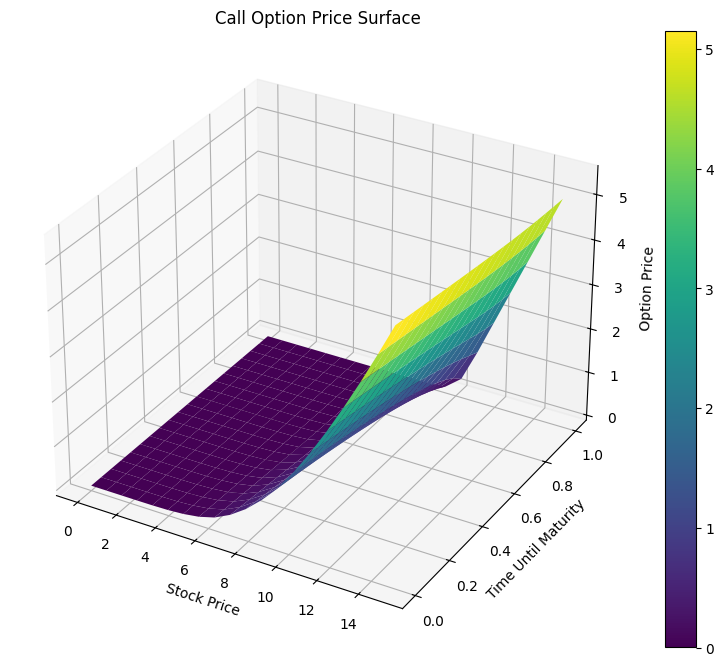

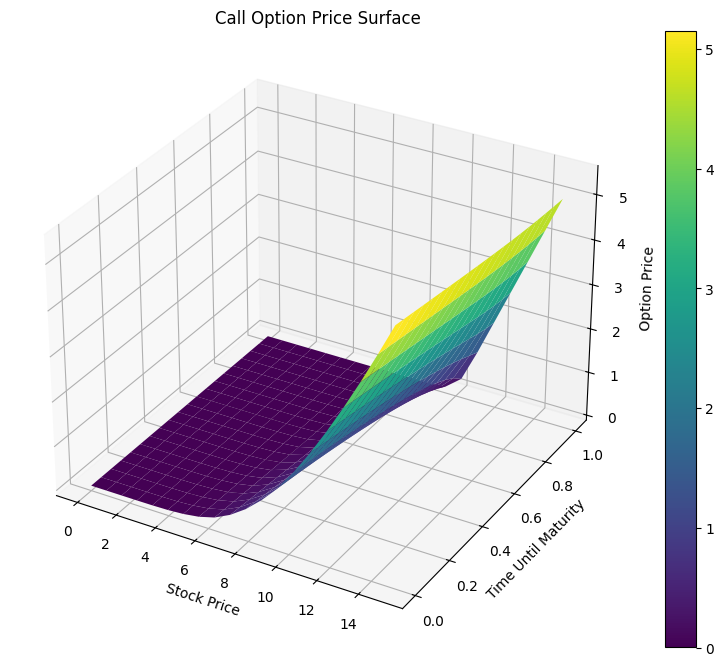

In [37]:
# Example usage
N, M = 100, 100
Smin, Smax = 0.4, 100
T, K = 1, 10
volatility, r, d = 0.4, 0.02, 0
is_call = True

# Calculate option prices
t_vals, S_vals, surface = black_scholes_implicit(
    N, M, Smin, Smax, T, K, volatility, r, d, is_call
)

# Plot the surface
plot_option_surface(t_vals, S_vals, surface, K, "Call Option Price Surface")


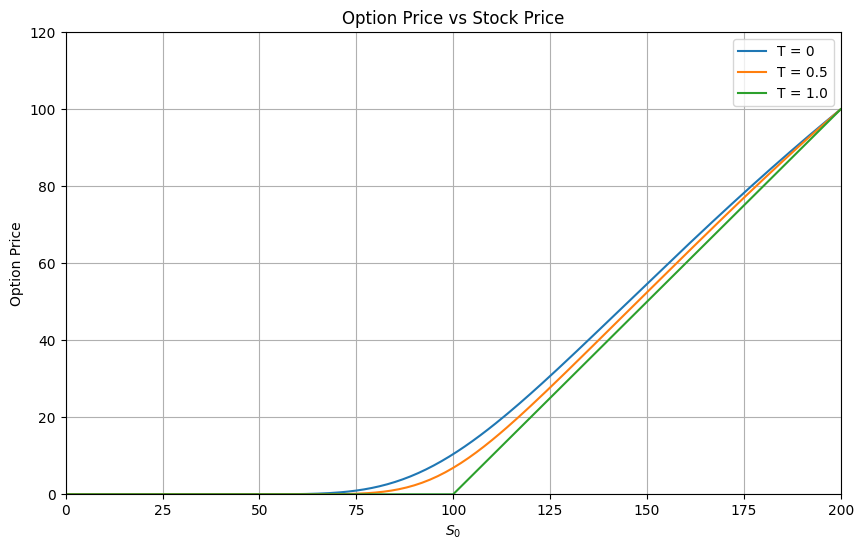

In [40]:
# Run Black-Scholes solver with adjusted parameters
t_vals, S_vals, surface = black_scholes_implicit(
    N=100,          # Time steps
    M=200,          # Stock price steps
    Smin=0,         # Minimum stock price
    Smax=200,       # Maximum stock price
    T=1,            # Time to maturity
    K=100,          # Strike price
    volatility=0.2, # Volatility
    r=0.05         # Risk-free rate
)

# Create plot
plot_option_time_slices(t_vals, S_vals, surface, K=100)
plt.show()